In the previous section with one sample example we saw how to train a Neural Network from scratch. In this notebook we'll use nn.Module and nn.Parameter along with autograd, optim utility packages provided within PyTorch. We subclass nn.Module (which itself is a class and able to keep track of state). nn.Module has a number of attributes and methods (such as .parameters() and .zero_grad()) which we will be using to perform different operations required. 

In this tutorial ,  we will create a Deep Learning model for building a handwritten digit classifier. We will make use of the MNIST dataset included in the torchvision package.
 
<b>Data Preprocessing</b>:

 Mandatory first step is to do the basic data pre-processing steps , using the a utility called <b>transforms</b> which comes from torchvision package.
 
 We will do two below mentioned basic data preprocessing operations (this will be explained more detail in case of CNN tutorial).
 
- Transform the raw dataset into tensors.
- Normalize the dataset.

We will also import the dataset from torch vision package.

In [1]:
import torch
from torchvision.datasets import MNIST

In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [3]:
# choose the training
train_data = MNIST(root='data', train=True,
                                   download=True, transform=transform)

In [4]:
#size of train data
len(train_data)

60000

In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 50

Data Loader helps us to create batches of data , we will go deeper into DataLoader in next tutorial

In [6]:
import numpy as np
from torch.utils.data import DataLoader

# data loader preparation
train_loader = DataLoader(train_data, batch_size=batch_size,num_workers=num_workers)

In [7]:
# Let's check the shape of the input/target data
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([50, 1, 28, 28])
torch.Size([50])


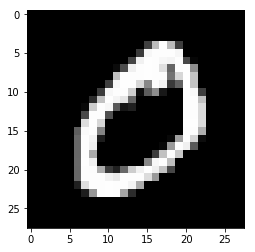

In [30]:
# Checking an sample image , data
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [29]:
# storing it for prediction , once the model is trained
img_zero = images[1]

As we can see that input data is not flattened to pass through the linear layers. Network can only accept a vector. 

So we will need to reshape the batch in a format of (batch size , no of features).

number of features -> 1 * 28 * 28 = 784

Shape of target data is as expected.

### Architecture

We create a new class (which inherits the properties from the base class from nn package called Module) to define the archietecture of the Neural Network. 

- Layer defination should be inside the constructor of the class.
- Forward propagation step should be included inside forward method.

Activations(Relu,Sigmoid,Tanh etc) and loss functions(cross entropy,nllloss etc) comes from torch.nn.functional. This module contains all the functions in the torch.nn module.

Syntax of nn.Linear() is (input size, output size)

This NN architecture below represents the 784 nodes (28*28 pixels) in the input layer, 256 in the hidden layer, and 10 in the output layer(0-9 numbers). Inside the forward function, we will use the relu activation function in the hidden layer which present under torch.nn.functional module.

In [15]:
from torch import nn, optim
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        # input tensor is flattened 
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [16]:
model = Model()

Now we will define the loss and optimizer functions

- <b>Loss Function</b> : Here we have used the CrossEntropyLoss() function.Generally loss assigned to `criterion`. for MNIST classification , we generally use softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss.

Few things to keep in mind while using the CrossEntropyLoss() in Pytorch 

    - CrossEntropyLoss criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
    - The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function.That's why there is no activation after self.fc2(x).

Here is a great article to understand Pytorch's Loss functions from scratch - https://medium.com/@zhang_yang/pytorch-loss-funtions-in-plain-python-b79c05f8b53f

- <b>Optimizer</b> : Pytorch also has a package with various optimization algorithms, torch.optim. We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter.Below are the few availavle optimizer in pytorch -

    - optim.Adam
    - optim.RMSprop
    - optim.SGD
    - optim.Adagrad

Learn more about optimizers from Andrew Ng- https://www.youtube.com/watch?v=4qJaSmvhxi8&list=PL9fbVgKf1HGwmWyfsc14iMsBSsluM5bCP

In the optimizer we need to pass model parameters(can be accesed using model.parameters()) for the back propagation operation.

In [17]:
criterion = nn.CrossEntropyLoss()

from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.01)

<b>Traning the Model:<b>

In [18]:
for epoch in range(1, 11): ## run the model for 10 epochs
    train_loss = []
    
    ## training part 
    
    for data, target in train_loader:
        optimizer.zero_grad()
        ## 1. forward propagation
        output = model(data)
        
        ## 2. loss calculation
        loss = criterion(output, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        train_loss.append(loss.item())
        
    print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss))

Epoch: 1 Training Loss:  0.6522858945839107
Epoch: 2 Training Loss:  0.3400297284250458
Epoch: 3 Training Loss:  0.2977698540516819
Epoch: 4 Training Loss:  0.26874281287193297
Epoch: 5 Training Loss:  0.24427759759438536
Epoch: 6 Training Loss:  0.22300724969400715
Epoch: 7 Training Loss:  0.2044730270622919
Epoch: 8 Training Loss:  0.18847376090784868
Epoch: 9 Training Loss:  0.1745395333141399
Epoch: 10 Training Loss:  0.16248214037933698


Few Steps to note:

- <b>optimizer.zero_grad()</b>: - will zero out the gradients from previous traning step , in this way gradients won't be   accumulated. This should be done before calculating the gradients at each epoch.
- <b>criterion(output, target)</b>: - we feed in the model predicted values along with actual values to calculate the loss.
- <b>optimizer.step()</b>: Once we call loss.backward() , gradients will be calculated and we will use this gradients to update the weights in this step using the learning rate defined in optim.SGD(model.parameters(), lr=0.01).

## Creating the model with F.log_softmax + nn.NLLLoss()

In [25]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [26]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [27]:
for epoch in range(1, 6): ## run the model for 5 epochs
    train_loss = []
    
    ## training part 
    
    for data, target in train_loader:
        optimizer.zero_grad()
        ## 1. forward propagation
        output = model(data)
        
        ## 2. loss calculation
        loss = criterion(output, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        train_loss.append(loss.item())
        
    print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss))

Epoch: 1 Training Loss:  0.37074759137739116
Epoch: 2 Training Loss:  0.1929439957527211
Epoch: 3 Training Loss:  0.15418797801214776
Epoch: 4 Training Loss:  0.13239779170330923
Epoch: 5 Training Loss:  0.12347747919235795
Epoch: 6 Training Loss:  0.11238287260498812
Epoch: 7 Training Loss:  0.10532260832308869
Epoch: 8 Training Loss:  0.09786521852752533
Epoch: 9 Training Loss:  0.09384211948209364
Epoch: 10 Training Loss:  0.08986101426683793


#### Now how to do Prediction?

In [32]:
# Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img_zero))

In [42]:
print(ps)
print(ps.shape)

tensor([[1.0000e+00, 6.5719e-31, 8.2037e-13, 1.3680e-14, 1.0173e-23, 3.3625e-14,
         8.8401e-13, 1.7751e-15, 7.8653e-21, 1.6690e-12]],
       grad_fn=<ExpBackward>)
torch.Size([1, 10])


With the probabilities, we can get the most likely class using the ps.topk method. This returns the  𝑘  highest values. Since we just want the most likely class, we can use ps.topk(1). This returns a tuple of the top- 𝑘  values and the top- 𝑘  indices. If the highest value is the fifth element, we'll get back 4 as the index

In [34]:
top_p, top_class = ps.topk(1, dim=1)

In [36]:
top_p 

tensor([[1.]], grad_fn=<TopkBackward>)

In [37]:
top_class

tensor([[0]])